In [ ]:
!pip install torch
!pip install transformers
!pip install scikit-learn
!pip install matplotlib

from google.colab import drive
drive.mount('/content/drive')

import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

In [17]:
def load_data(file_path):
    sentences = []
    labels = []
    with open(file_path, 'r') as file:
        for line in file:
            sentence, emotion = line.strip().split(';')
            sentences.append(sentence)
            labels.append(emotion_to_label_id[emotion])
    return sentences, labels

train_file_path = "/content/drive/MyDrive/research-paper/train.txt"
test_file_path = "/content/drive/MyDrive/research-paper/test.txt"
emotion_to_label_id = {'fear': 0, 'love': 1, 'anger': 2, 'surprise': 3, 'sadness': 4, 'joy': 5}

train_sentences, train_labels = load_data(train_file_path)
test_sentences, test_labels = load_data(test_file_path)

In [18]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def preprocess_data(sentences, labels):
    inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")
    labels = torch.tensor(labels)
    return inputs, labels

train_inputs, train_labels = preprocess_data(train_sentences, train_labels)
test_inputs, test_labels = preprocess_data(test_sentences, test_labels)

train_dataset = TensorDataset(train_inputs['input_ids'], train_inputs['attention_mask'], train_labels)
test_dataset = TensorDataset(test_inputs['input_ids'], test_inputs['attention_mask'], test_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [19]:
class BERTContextAwareEmotionRecognition(torch.nn.Module):
    def __init__(self, num_labels):
        super(BERTContextAwareEmotionRecognition, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.logits

In [23]:
def train_model(model, train_loader, num_epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        correct_predictions = 0

        for input_ids, attention_mask, labels in train_loader:
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            optimizer.zero_grad()
            logits = model(input_ids, attention_mask)
            loss = torch.nn.functional.cross_entropy(logits, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            predicted_labels = logits.argmax(dim=1)
            correct_predictions += (predicted_labels == labels).sum().item()

        avg_loss = total_loss / len(train_loader)
        train_accuracy = correct_predictions / len(train_dataset)
        train_loss_history.append(avg_loss)
        train_acc_history.append(train_accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    return model, train_loss_history, train_acc_history

num_labels = len(emotion_to_label_id)
model = BERTContextAwareEmotionRecognition(num_labels)
trained_model, train_loss_history, train_acc_history = train_model(model, train_loader)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5, Train Loss: 0.4680, Train Accuracy: 0.8364
Epoch 2/5, Train Loss: 0.1339, Train Accuracy: 0.9396
Epoch 3/5, Train Loss: 0.1019, Train Accuracy: 0.9519
Epoch 4/5, Train Loss: 0.0884, Train Accuracy: 0.9569
Epoch 5/5, Train Loss: 0.0804, Train Accuracy: 0.9603


In [21]:
def evaluate_model(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for input_ids, attention_mask, labels in data_loader:
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            logits = model(input_ids, attention_mask)
            predicted_labels = logits.argmax(dim=1)
            predictions.extend(predicted_labels.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    f1 = f1_score(true_labels, predictions, average='weighted')
    return f1

test_f1_score = evaluate_model(trained_model, test_loader)
print(f"Test F1 Score: {test_f1_score:.4f}")

Test F1 Score: 0.9310


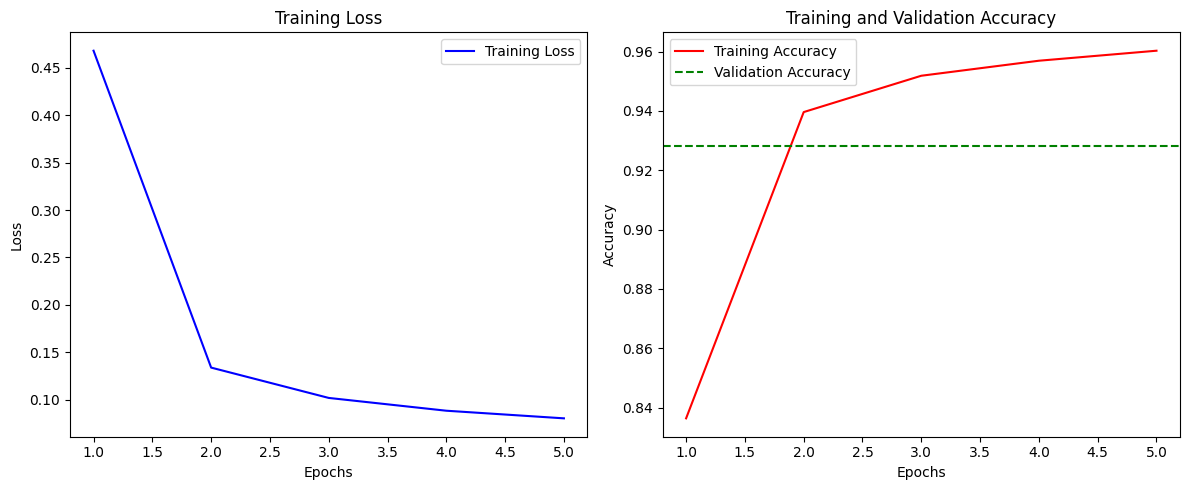

In [24]:
def plot_metrics(train_loss_history, train_acc_history, test_acc):
    epochs = range(1, len(train_loss_history) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss_history, 'b', label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc_history, 'r', label='Training Accuracy')
    plt.axhline(y=test_acc, color='g', linestyle='--', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

test_accuracy = evaluate_model(trained_model, test_loader)
plot_metrics(train_loss_history, train_acc_history, test_accuracy)